<a href="https://colab.research.google.com/github/adenilso/sucupira-indicadores/blob/master/Sucupira_Indicadores_Quadrienal_2017_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para geração dos gráficos

##Setup

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import io
from plotnine import *
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

Mounted at /content/drive


In [ ]:
estratos = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
estratos.reverse()

In [ ]:
pesos = dict({"B4": 0.05,
               "B3": 0.10,
               "B2": 0.20,
               "B1": 0.50,
               "A4": 0.625,
               "A3": 0.75, 
               "A2": 0.875,
               "A1": 1.0,
               "C": 0
              })
cat_map = dict(
    [('DISCENTE BACHARELADO', 'GRAD'),
     ('DISCENTE DOUTORADO', 'DISCENTE'),
     ('DISCENTE DOUTORADO PROFISSIONAL', 'DISCENTE'),
     ('DISCENTE MESTRADO', 'DISCENTE'),
     ('DISCENTE MESTRADO PROFISSIONAL', 'DISCENTE'),
     ('DOCENTE COLABORADOR', 'DOCENTE COLABORADOR'),
     ('DOCENTE PERMANENTE', 'DOCENTE PERMANENTE'),
     ('DOCENTE VISITANTE', 'DOCENTE VISITANTE'),
     ('EGRESSO', 'DISCENTE'),
     ('EGRESSO_GERAL_5_ANOS', 'DISCENTE'),
     ('PARTICIPANTE EXTERNO', 'PARTICIPANTE EXTERNO'),
     ('PÓS-DOC', 'PÓS-DOC')
    ]
  )
niveismap = dict({
    "MESTRADO": "M",
    "MESTRADO/DOUTORADO": "MD",
    "MESTRADO PROFISSIONAL": "M",
    "MESTRADO PROFISSIONAL/DOUTORADO PROFISSIONAL": "MD",
    "DOUTORADO": "D"
  })

In [ ]:
def carregar_planilhas(sheetnames):
  path = '/content/drive/My Drive/CAPES2018-2021/Quadrienal 2017-2020/Indicadores/'
  sheets = dict([[sn, pd.read_csv(path + 'N-' + sn + '.csv', error_bad_lines=False)] for sn in sheetnames])
  return sheets

In [ ]:
sheetnames = ['producoes_lista', 'programas', 'docentes', 'discentes', 'tcc'] 
sheets = carregar_planilhas(sheetnames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (7,14,76) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (7,32) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
if False:
  path = '/content/drive/My Drive/CAPES2018-2021/Quadrienal 2017-2020/Indicadores/'
  filename = path + '2. CIENCIA_DA_COMPUTACAO_INDICADORES-sem algumas abas' + '.xlsx'
  sheets = dict()
  sheets['tcc'] = pd.read_excel(filename, sheet_name='tcc', skiprows=6)
  sheets['producoes_lista'] = pd.read_excel(filename, sheet_name='producoes_lista', skiprows=5)
  sheets['programas'] = pd.read_excel(filename, sheet_name='programas', skiprows=4)
  sheets['docentes'] = pd.read_excel(filename, sheet_name='docentes', skiprows=6)
  sheets['discentes'] = pd.read_excel(filename, sheet_name='discentes', skiprows=6)
  for k in sheets.keys():
    sheets[k].to_csv(path + 'N-' + k + '.csv')

In [ ]:
producoes = sheets['producoes_lista']
docentes = sheets['docentes']
programas = sheets['programas']
campos = ["Cod PPG", "Sigla", "Nome PPG", "Modalidade", "Ano Início Nível", "Nível"]
siglas = programas \
  .rename(columns={"IES Principal Sigla": "Sigla"}) \
  .groupby(campos) \
  .size() \
  .reset_index() \
  [campos]
notas = programas[["Cod PPG", "Nota"]]
notas["Nota"] = notas["Nota"].apply(lambda x: str(x))
siglas = pd.merge(siglas[campos], notas, on="Cod PPG")
siglas['NotaStr'] = siglas['Nota'].apply(lambda x: str(x))
siglas['Modalidade'] = siglas['Modalidade'].apply(lambda x: x[0])
siglas['Ano Início Nível'] = siglas['Ano Início Nível'].apply(lambda x: x[0:4])

for key, value in niveismap.items():
  siglas.loc[siglas['Nível'] == key, ['Nível']] = value

siglas['Acronym'] = siglas['Nome PPG'] \
  .apply(lambda x: ''.join(map(lambda s: s[0], filter(lambda s: len(s) > 5, x.split(' ')))))
siglas['SiglaTmp'] = siglas['Sigla'] +  \
  '-' + siglas['Acronym'] + \
  '-' + siglas['NotaStr'] + \
  ' (' + siglas['Nível'] + '-' + siglas['Modalidade'] + '-' + siglas['Ano Início Nível'] + ')'
siglas['Sigla'] = siglas['SiglaTmp']
siglas=siglas.drop(columns=['Nome PPG', 'Nota', 'NotaStr', 'Acronym', 'SiglaTmp', 'Modalidade', 'Ano Início Nível', 'Nível'])
siglas=siglas.groupby(['Cod PPG', 'Sigla']).sum().reset_index()
anos=programas[['Cod PPG', 'Ano Base']].groupby(['Cod PPG']).size().reset_index().rename(columns={0: 'QteAnos'})



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Funcões de Sumarização

In [ ]:
def sumarizar_docs(docs):
  res = pd.DataFrame({"Cod PPG": list(set(docs["Cod PPG"].values))})
  for tipo in ["PERMANENTE", "COLABORADOR"]: 
    p = docs.loc[
              docs["Categoria"] == tipo,
            ["Cod PPG", "Categoria"]
    ].groupby(by=["Cod PPG"]).count().rename(columns={"Categoria": tipo})
    #p.loc[p[tipo].isnull()]
    res = pd.merge(res, p, on="Cod PPG", how="left")
    res = res.fillna(0)
  #for tipo in ["PERMANENTE", "COLABORADOR"]:
  #  res.loc[res[tipo].isnull(), [tipo]] = 0
  return res

In [ ]:
sumario_docentes = sumarizar_docs(docentes.loc[docentes["Modalidade"] == "ACADÊMICO"])

In [ ]:
def sumarizar_prod(prod):
  cods = pd.DataFrame({
        "Cod PPG": list(set(prod["Cod PPG"].values))
      })
  res = pd.DataFrame()
  for tipo in ["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"]:
    r = cods.assign(Subtipo = tipo)
    for estrato in estratos: 
      p = prod.loc[
              (prod["Natureza"] == "TRABALHO COMPLETO") &
              (prod["Estrato"] == estrato), 
            ["Cod PPG", "Estrato"]
      ].groupby(by=["Cod PPG"]).count()
      r = pd.merge(r, p, on="Cod PPG", how="left").rename(columns={"Estrato": estrato})
    res = pd.concat([res, r])
  res = res.fillna(0)
  return res

In [ ]:
sumario_prod = sumarizar_prod(producoes.loc[
                                            (producoes["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"]))
                                            ])

In [ ]:
def sumarizar_tcc(tcc):
  res = pd.DataFrame({"Cod PPG": list(set(tcc["Cod PPG"].values))})
  for tipo in ["DISSERTAÇÃO", "TESE"]: 
    p = tcc.loc[
              (tcc["Subtipo"] == tipo), 
            ["Cod PPG", "Subtipo"]
    ].groupby(by=["Cod PPG"]).count()
    res = pd.merge(res, p, on="Cod PPG", how="left").rename(columns={"Subtipo": tipo})
  return res

In [ ]:
def ponderar_por_docs(data, docs, campos):
  res = pd.merge(data, docs, on=["Cod PPG"], how="left")
  res = res.loc[res["PERMANENTE"] + res["COLABORADOR"] > 0]
  for campo in campos:
    res.loc[:, [campo]] = res[campo] / (res["PERMANENTE"] + res["COLABORADOR"])
  return res

In [ ]:
def ponderar_por_ano(data, anos, campos):
  res = pd.merge(data, anos, on=["Cod PPG"], how="left")
  for campo in campos:
    res.loc[:, [campo]] = res[campo] / (res["QteAnos"])
  return res

In [ ]:
sumario_tcc = sumarizar_tcc(sheets["tcc"])

In [ ]:
def processar_autores(autores):
  res = []
  for i, autor in enumerate(autores):
    found = re.search('(.*) \((.*)\)', autor)
    if found:
      res.append([i+1, found.group(1), found.group(2)])
  return res

In [ ]:
def sumarizar_autores(prod):
  wd = prod
  wd = wd[
                (wd['Subtipo'].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"])) &
                (wd['Natureza'] == "TRABALHO COMPLETO")
      ]
  wd = wd[wd['ID_ADD_PRODUCAO_INTELECTUAL'].notnull()]
  wd = wd[['Cod PPG', 'ID_ADD_PRODUCAO_INTELECTUAL', 'NM_AUTORES']]
  idsProd = wd['ID_ADD_PRODUCAO_INTELECTUAL'].values.tolist()
  wdsplt = [str(l).split(' | ') for l in wd['NM_AUTORES'].values]
  cols = ['ID_ADD_PRODUCAO_INTELECTUAL'] + list(range(max([len(x) for x in wdsplt])))
  wdsplt = [[idsProd[i]] + wdsplt[i] for i in range(len(wdsplt))]
  wdsplt = pd.DataFrame(wdsplt, columns=cols)
  wd = wd.merge(wdsplt, on='ID_ADD_PRODUCAO_INTELECTUAL', how='left')
  wd = wd.melt(id_vars=['Cod PPG', 'ID_ADD_PRODUCAO_INTELECTUAL', 'NM_AUTORES'], var_name="Pos", value_name="NomeCat")
  wd = wd[wd["NomeCat"].notnull()]
  wd.loc[:, ['NomeRe']] = wd['NomeCat'].apply(lambda x: re.search('(.*) \((.*)\)', x))
  wd.loc[wd['NomeRe'].isnull(), ['Nome']] = wd.loc[wd['NomeRe'].isnull(), ['NM_AUTORES']]
  wd.loc[wd['NomeRe'].isnull(), ['Cat']] = 'NOCAT'
  wd.loc[wd['NomeRe'].notnull(), ['Nome', 'Cat']] = wd[wd['NomeRe'].notnull()]['NomeRe'].apply(lambda x: x.group(1))
  wd.loc[wd['NomeRe'].notnull(), ['Cat']] = wd[wd['NomeRe'].notnull()]['NomeRe'].apply(lambda x: cat_map[x.group(2)])
  wd = wd.drop(columns=["NM_AUTORES", "NomeCat", "NomeRe"])
  wd['Pos'] = wd['Pos'] + 1
  wd = prod[['Cod PPG', 'Estrato', 'ID_ADD_PRODUCAO_INTELECTUAL', 'Subtipo', 'Natureza', 'Ano base']].merge(wd, on=['Cod PPG', 'ID_ADD_PRODUCAO_INTELECTUAL'], how='right')
  wd = wd.rename(columns={'ID_ADD_PRODUCAO_INTELECTUAL': 'idProd', 'Nome': 'Nome do docente'})

  return wd

In [ ]:
#sumario_autores = sumarizar_autores(producoes.loc[
#                                            (producoes["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"])) &
#                                            (producoes["Natureza"] == "TRABALHO COMPLETO")
#                                            ])

In [ ]:
sumario_autores = sumarizar_autores(producoes)

In [ ]:

sumario_autores[sumario_autores['Nome do docente'] == 'ALESSANDRO FABRICIO GARCIA']

,Cod PPG,Estrato,idProd,Subtipo,Natureza,Ano base,Pos,Nome do docente,Cat
11208,31005012004P9,A2,29066315.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2017.0,1,ALESSANDRO FABRICIO GARCIA,DOCENTE PERMANENTE
11267,31005012004P9,A2,29066271.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2017.0,1,ALESSANDRO FABRICIO GARCIA,DOCENTE PERMANENTE
11312,31005012004P9,A1,29066162.0,ARTIGO EM PERIÓDICO,TRABALHO COMPLETO,2017.0,1,ALESSANDRO FABRICIO GARCIA,DOCENTE PERMANENTE
11313,31005012004P9,A3,29066161.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2017.0,1,ALESSANDRO FABRICIO GARCIA,DOCENTE PERMANENTE
11382,31005012004P9,A3,29066475.0,ARTIGO EM PERIÓDICO,TRABALHO COMPLETO,2018.0,1,ALESSANDRO FABRICIO GARCIA,DOCENTE PERMANENTE
...,...,...,...,...,...,...,...,...,...
120612,24009016005P0,A3,31526334.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2020.0,9,ALESSANDRO FABRICIO GARCIA,PARTICIPANTE EXTERNO
120613,24009016005P0,A2,31526299.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2020.0,9,ALESSANDRO FABRICIO GARCIA,PARTICIPANTE EXTERNO
121096,40004015019P5,A2,31623855.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2020.0,9,ALESSANDRO FABRICIO GARCIA,PARTICIPANTE EXTERNO
121332,12001015012P2,A3,29818376.0,TRABALHO EM ANAIS,TRABALHO COMPLETO,2017.0,10,ALESSANDRO FABRICIO GARCIA,PARTICIPANTE EXTERNO


In [ ]:
producoes=producoes \
            .rename(columns={"ID_ADD_PRODUCAO_INTELECTUAL": "idProd"}) \
            .merge(
              sumario_autores.loc[sumario_autores["Cat"] == "DISCENTE"].groupby("idProd").size().reset_index().rename(columns={0: "QteDiscente"}),
              on=["idProd"], how="left"
            ).fillna(0)

In [ ]:
sumario_prod_disc = sumarizar_prod(producoes.loc[
                                            (producoes["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"])) &
                                            (producoes["QteDiscente"] > 0)
                                            ])

In [ ]:
def juntar_dados_hist(data, autores, nome='Nome do docente', qte="Qte"):
  d = pd.DataFrame(data.loc[:, ['Cod PPG', nome]].groupby(['Cod PPG', nome]).size().reset_index().values, columns=['Cod PPG', nome, 'dummy'])
  qte_pub = pd.DataFrame(pd.DataFrame(autores.groupby([nome, 'Cod PPG']).size()).reset_index().values, columns=[nome, "Cod PPG", qte])
  res = pd.merge(d, qte_pub, on=[nome, 'Cod PPG'], how="left")
  res[qte] = res[qte].fillna(0.0)
  return res

In [ ]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    #array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [ ]:
def juntar_dados_gini(data, dqte, nome='Nome do docente', qte="Qte"):
  d = pd.DataFrame(data.loc[:, ['Cod PPG', nome]].groupby(['Cod PPG', nome]).size().reset_index().values, columns=['Cod PPG', nome, 'dummy'])
  qte_pub = pd.DataFrame(pd.DataFrame(dqte.groupby([nome, 'Cod PPG']).size()).reset_index().values, columns=[nome, "Cod PPG", qte])
  res = pd.merge(d, qte_pub, on=[nome, 'Cod PPG'], how="left")
  res = res.fillna(0.0)
  res = res.groupby(['Cod PPG']).apply(lambda x: gini(np.array(x['Qte']))).reset_index().rename(columns={0: 'Gini'})
  return res

In [ ]:
def adicionar_percentis(gg, data, col="Qte", percentis=[0, 0.25, 0.5, 0.75, 1], nomes=["Min", "1Q", "Mediana", "3Q", "Max"]):
    wd = data[["Sigla", col]].groupby(["Sigla"]).sum().reset_index()
    parts = [0, 0.25, 0.5, 0.75, 1]
    d = []
    for i in range(len(percentis)):
      p = percentis[i]
      n = nomes[i]
      d.append([1, wd[col].quantile(p), n])
    t = pd.DataFrame(data=d, columns=['x', 'y', 'l'])
    color='black'
    ngg = (
        gg
        + geom_hline(t, aes(yintercept = 'y'), color=color)
        + geom_label(t, aes(x='x', y='y', label='l'), fill='white', ha='left', va='top', color=color)
    )
    return ngg

##Funções de Plotagens

In [ ]:
def plotPublicacaoQualis(data, titulo="Qualis Per", fill="Estrato", addmedian=False, ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]]):
  #fill="Estrato"
  wd = data
  wd = pd.merge(wd, siglas, on="Cod PPG", how="left")
  wd = pd.melt(wd, id_vars=["Sigla", "Subtipo"], value_vars=estratos, var_name="Estrato", value_name="Qte")
  wd = wd[(pd.notnull(wd["Sigla"])) & (pd.notnull(wd["Qte"]))]
  wd = wd[wd["Estrato"].isin(estratos)]
  Estrato_cat = pd.Categorical(wd["Estrato"], categories=estratos)
  wd = wd.assign(Estrato = Estrato_cat)
  #ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]] / e['Média Docentes']
  wd = wd.assign(QtePeso = wd.apply(ponderamento, axis=1))
  order = wd[["Sigla", "QtePeso"]].groupby(by="Sigla")["QtePeso"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(wd["Sigla"], categories=order)
  wd = wd.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(wd)
    + aes(x="Sigla_cat", y="QtePeso", fill=fill)
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend=fill)
    + ggtitle(titulo)
  )
  if addmedian:
    gg = adicionar_percentis(gg, wd, col="QtePeso")
  return gg

In [ ]:
def plotDocentes(data, titulo):
  docs = pd.merge(data, siglas, on="Cod PPG", how="left")
  docs = pd.melt(docs, id_vars=["Sigla"], value_vars=["PERMANENTE", "COLABORADOR"], var_name="Modalidade", value_name="Qte")
  docs = docs[(pd.notnull(docs["Sigla"])) & (pd.notnull(docs["Qte"]))]
  mod_cat = pd.Categorical(docs["Modalidade"], categories=["COLABORADOR", "PERMANENTE"])
  docs = docs.assign(Modalidade = mod_cat)
  order = docs[["Sigla", "Qte"]].groupby(by="Sigla")["Qte"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(docs["Sigla"], categories=order)
  docs = docs.assign(Sigla_cat = Sigla_cat)
  docs = docs.loc[(docs['Qte'] > 0)] 
  gg = (
    ggplot(docs)
    + aes(x="Sigla_cat", y="Qte / 4", fill="Modalidade")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

In [ ]:
def plottcc(data, tipo, titulo, ponderar=None, incluirPub=None):
  wd = data
  parciais = dict()
  parciais['Tot'] = wd[["Cod PPG", "Nome do Discente"]] \
    .groupby(["Cod PPG"]).count().reset_index() \
    .rename(columns={"Nome do Discente": "Tot"})
  if type(incluirPub) is list:
    tipos = list(filter(lambda tipo: tipo in incluirPub, ["Tot", "Pub", "Per", "Pri"]))
    if not "Tot" in tipos:
      tipos = ["Tot"] + tipos
    wdpub = wd[["Cod PPG", "Nome do Discente"]].merge(sumario_autores.rename(columns={"Nome do docente": "Nome do Discente"}), on=["Cod PPG", "Nome do Discente"], how="inner")
    wdpub = wdpub[
          (wdpub["Natureza"] == "TRABALHO COMPLETO") &
          (wdpub["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"]))
        ]
#  wdpub = wdtot
    wdper = wdpub[wdpub["Subtipo"] == "ARTIGO EM PERIÓDICO"]
    wdpri = wdper[wdper["Pos"] == 1]
    for (tipo, data) in [("Pub", wdpub), ("Per", wdper), ("Pri", wdpri)]:
      parciais[tipo] = data[["Cod PPG", "Nome do Discente", "idProd"]] \
                  .groupby(["Cod PPG", "Nome do Discente"]) \
                  .count().reset_index().drop('idProd',axis=1) \
                  .groupby(["Cod PPG"]).count().reset_index() \
                  .rename(columns={"Nome do Discente": tipo})

    res = parciais['Tot']
    for tipo in ["Pub", "Per", "Pri"]:
      res = res.merge(parciais[tipo], on="Cod PPG", how="left")

  else:
    res = parciais['Tot']
    tipos = ["Tot"]
  if not ponderar is None:
    pond = pd.DataFrame(ponderar)
    res = res.merge(pond, on="Cod PPG", how="left")
    #return res
    for tipo in tipos:
      res[tipo] = res[tipo] / res['Qte']
    res = res.drop('Qte', axis=1)

  wd = res
  wd = wd.merge(siglas, on="Cod PPG", how="left")
  order = wd[["Sigla", "Tot"]].groupby(by="Sigla")["Tot"].sum().sort_values().keys().tolist()
  order.reverse()
  wd = wd.melt(id_vars=["Sigla"], value_vars=tipos, var_name="Trabalho", value_name="Qte").fillna(0)
  #return wd
  #wd = wd[(pd.notnull(wd["Sigla"])) & (pd.notnull(wd["Qte"])) & (wd["Modalidade"] == tipo)]
  wd['Trabalho'] = pd.Categorical(wd["Trabalho"], categories=tipos)
  wd['Sigla'] = pd.Categorical(wd["Sigla"], categories=order)
  gg = (
    ggplot(wd)
    + aes(x="Sigla", y="Qte", fill="Trabalho")
    + geom_bar(stat="identity", alpha=1, position=position_dodge())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

In [ ]:
def plotCapela(data, nome='Nome do docente', qte='Qte'):
  d = data.loc[:, ['Cod PPG', 'Nome do docente', 'Qte']].groupby(['Cod PPG', 'Nome do docente']).sum().reset_index().sort_values(by=["Cod PPG", "Qte"], ascending=True)
  r = pd.merge(d, siglas, on=['Cod PPG'], how="left").sort_values(by="Sigla", kind="stable")
  r = r.assign(idx=range(len(r.index)))
  idxgrp = r.loc[:, ['Sigla', 'idx']].groupby('Sigla')
  idxmin = idxgrp.min().reset_index().rename({'idx': 'min'})
  idxmax = idxgrp.max().reset_index().rename({'idx': 'max'})
  breaks = pd.merge(idxmin, idxmax, on="Sigla")
  breaks = breaks.assign(pos=(breaks['idx_x'] + breaks['idx_y']) / 2)
  labels = breaks['Sigla'].values.tolist()
  xbreaks = breaks['pos'].values.tolist()
  gg = (
    ggplot(r)
    + aes(x='idx', y='Qte')
    + theme(figure_size=(16.0, 9.0))
    + geom_area(fill='blue')
    + theme(axis_text_x=element_text(angle=90, size=6))    
    + scale_x_continuous(labels=labels, breaks=xbreaks)
  )
  return gg

In [ ]:
def plotHist(data, col='Gini', addmedian=False):
  wd = data
  wd = pd.merge(wd, siglas, on=['Cod PPG'], how='left')
  order=wd[['Sigla', col]].groupby(by='Sigla')[col].max().sort_values().keys().tolist()
  order.reverse()
  sigla_cat = pd.Categorical(wd['Sigla'], categories=order)
  wd = wd.assign(Sigla = sigla_cat)
  gg = (
      ggplot(wd)
      + aes(x='Sigla', y=col)
      + geom_bar(stat='identity', fill='blue', color='blue')
      + theme(figure_size=(16.0, 9.0))
      + theme(axis_text_x=element_text(angle=90, size=10))
  )
  if addmedian:
    gg = adicionar_percentis(gg, wd, col="Gini")
    return gg
    parts = [0, 0.25, 0.5, 0.75, 1]
    m = [r[col].quantile(p) for p in parts]
    t = pd.DataFrame(data=[[1, r[col].quantile(p),'{0:2.0f}%'.format(p*100)] for p in parts], columns=['x', 'y', 'l'])
    color='black'
    #return t
    gg = (
        gg
        + geom_hline(t, aes(yintercept = 'y'), color=color)
        + geom_label(t, aes(x='x', y='y', label='l'), ha='left', va='top', color=color)
    )
  return gg

In [ ]:
def plotNuvemPalavras(data, indices=None):
  words = data
  if not indices is None:
    words = [s.split(' ') for s in words]
    words = [[s[i] for i in indices] for s in words]
    words = [' '.join(s) for s in words]
  word_count_dict = Counter(words)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(word_count_dict)
  plt.figure(figsize = (16, 9), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
 
  plt.show()

In [ ]:
def plotIdiomas(data, titulo="", addmedian=False):
  wd = data
  wd = wd.groupby(["Cod PPG", "Subtipo", "Idioma"]).size().reset_index().rename(columns={0: "Qte"})

  wd = wd.pivot(index=["Cod PPG", "Subtipo"], columns=["Idioma"], values=["Qte"]).reset_index().fillna(0.0).values
  wd = pd.DataFrame(wd, columns=["Cod PPG", "Subtipo", "INGLES", "PORTUGUES"])
  wd['Total'] = wd['INGLES'] + wd['PORTUGUES']
  cols = ["INGLES", "PORTUGUES"]
  for col in cols:
    wd[col] = 100 * wd[col] / wd['Total']
  wd = wd.drop(['Total'], axis=1)
  wd = pd.merge(wd, siglas, on="Cod PPG", how="left")
  order = wd[["Sigla", "INGLES"]].groupby(by="Sigla")["INGLES"].sum().sort_values().keys().tolist()
  order.reverse()
  wd = pd.melt(wd, id_vars=["Sigla", "Subtipo"], value_vars=cols, var_name="Idioma", value_name="Qte")
  wd['Qte'] = pd.to_numeric(wd['Qte'])
  wd['Sigla'] = pd.Categorical(wd["Sigla"], categories=order)
  wd['Idioma'] = pd.Categorical(wd["Idioma"], categories=list(["PORTUGUES", "INGLES"]))
  gg = (
    ggplot(wd)
    + aes(x="Sigla", y="Qte", fill="Idioma")
    + geom_bar(stat="identity", position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade")
    + scale_y_continuous()
  )
  if addmedian:
    gg = adicionar_percentis(gg, wd[wd["Idioma"] == "INGLES"])
  return gg

In [ ]:
def plotNumDisc(data, addmedian=False):
  total_aut = data[["Cod PPG", "idProd", "Nome do docente"]] \
              .groupby(["Cod PPG", "idProd"]).count().reset_index() \
              .rename(columns={"Nome do docente": "Total"})
  total_dis = data[data["Cat"] == "DISCENTE"][["Cod PPG", "idProd", "Nome do docente"]] \
              .groupby(["Cod PPG", "idProd"]).count().reset_index() \
              .rename(columns={"Nome do docente": "NumDisc"})
  total = total_aut.merge(total_dis, on=["Cod PPG", "idProd"], how="left").fillna(0.0)
  perqte = total.groupby(["Cod PPG", "NumDisc"]).count().reset_index()
  wd = data[["Cod PPG"]].groupby("Cod PPG").count().reset_index()[["Cod PPG"]]
  rng = list(range(6))
  rng.reverse()
  for n in rng:
    wd = wd.merge(perqte[perqte["NumDisc"] == n][["Cod PPG", "idProd"]], on="Cod PPG", how="left").rename(columns={"idProd": n})
  wd = wd.fillna(0.0)
  wd = wd.merge(siglas, on="Cod PPG", how="left")
  mlt = wd.melt(id_vars=["Cod PPG", "Sigla"], value_vars=rng, var_name="NumDisc", value_name="Qte")

  total = mlt.groupby(["Cod PPG", "Sigla"]).sum().reset_index().rename(columns={"Qte": "Total"})
  wd = wd.merge(total, on=["Cod PPG", "Sigla"], how="left")
  for n in rng:
    wd[n] = wd[n] / wd['Total']
  wd = wd.drop("Total", axis=1)
  wd = wd.melt(id_vars=["Cod PPG", "Sigla"], value_vars=rng, var_name="NumDisc", value_name="Qte")
  order = wd[wd["NumDisc"] == 0].sort_values(by="Qte")["Sigla"].values.tolist()
  wd['NumDisc'] = pd.Categorical(wd["NumDisc"], categories=rng)
  wd['Sigla'] = pd.Categorical(wd["Sigla"], categories=order)
  #return wd

  gg = (
    ggplot(wd)
    + aes(x="Sigla", y="Qte", fill="NumDisc")
    + geom_bar(stat="identity", position=position_fill())
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
  )
  if addmedian:
    gg = adicionar_percentis(gg, wd[wd["NumDisc"] == 0], "Qte")

  return gg

#Gráficos

##Docentes

###Docentes permanentes – média por ano  (Dependendo do número de docentes ativos no programa todos os demais gráficos podem mudar)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


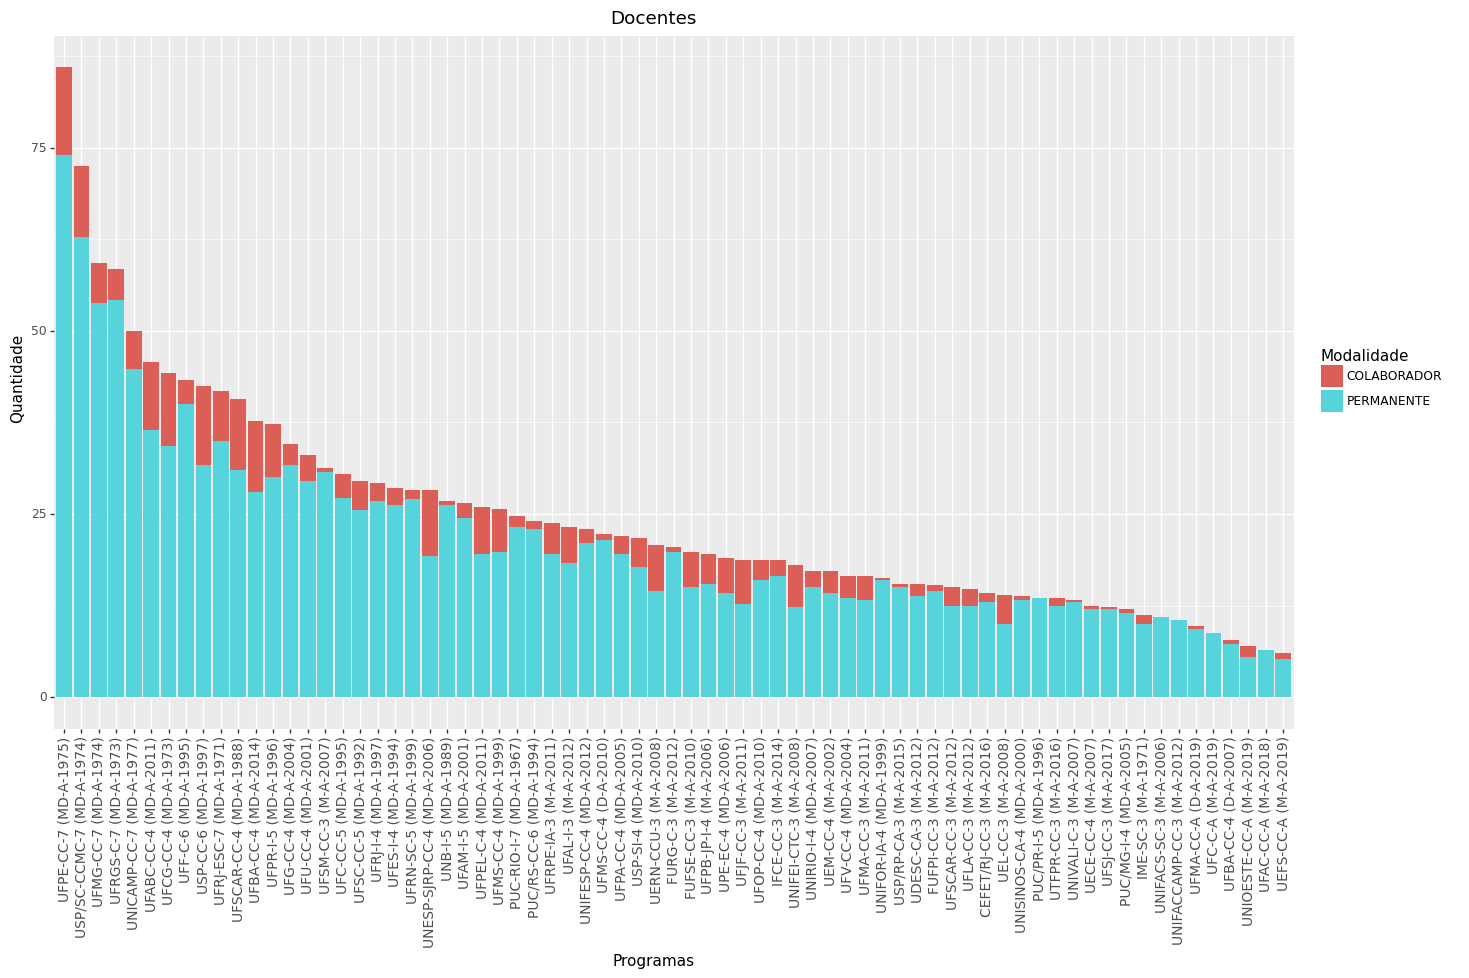

<ggplot: (8767103307517)>

In [ ]:
plotDocentes(sumario_docentes, "Docentes")

In [ ]:
docs = sheets['docentes']

wd = docs
wd = wd[wd['Categoria'] == 'PERMANENTE']
wd = wd[wd['Ano Base'] == 2020]
docsAno = wd[['Cod PPG', 'Categoria']].groupby(['Cod PPG']).count().reset_index() \
  .rename(columns={'Categoria': 'PERMANENTE'})

wd = wd[['Cod PPG', 'IES', 'Nome do docente', 'Ano Base']] \
  .groupby(['Cod PPG', 'IES', 'Nome do docente']).count().reset_index() \
  .drop(columns=['Ano Base']) \
  .groupby(['Cod PPG', 'IES']).count().reset_index() \
  .sort_values(by=['Cod PPG', 'Nome do docente'], ascending=False).groupby(['Cod PPG']).head(2) \
  .rename(columns={'Nome do docente': 'Qte'})

#res = wd

wd = wd.sort_values(['Cod PPG', 'Qte'], ascending=False)

wd = wd.assign(IES=[1, 2] * 85)

wd = wd.merge(docsAno, on='Cod PPG')

wd = wd.merge(siglas, on=['Cod PPG'], how='left')

wd = wd.assign(Porcentagem = wd['Qte'] / wd['PERMANENTE'])

#res = wd

order1 = wd.groupby(['Sigla']).sum().reset_index().sort_values('Porcentagem')['Sigla'].values
order2 = wd[wd['IES'] == 1].sort_values('Porcentagem')['Sigla'].values

wd['Sigla1'] = pd.Categorical(wd['Sigla'], categories=order1)
wd['Sigla2'] = pd.Categorical(wd['Sigla'], categories=order2)

gg = (
    ggplot(wd)
    + aes(x='Sigla2', y='Porcentagem', fill='IES')
    + geom_bar(stat="identity", position=position_stack(), show_legend=False)
    + theme(axis_text_x=element_text(angle=90, size=10))
    + theme(figure_size=(16.0, 9.0))
)

gg

NameError: ignored

##Teses

###Teses de doutorado

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


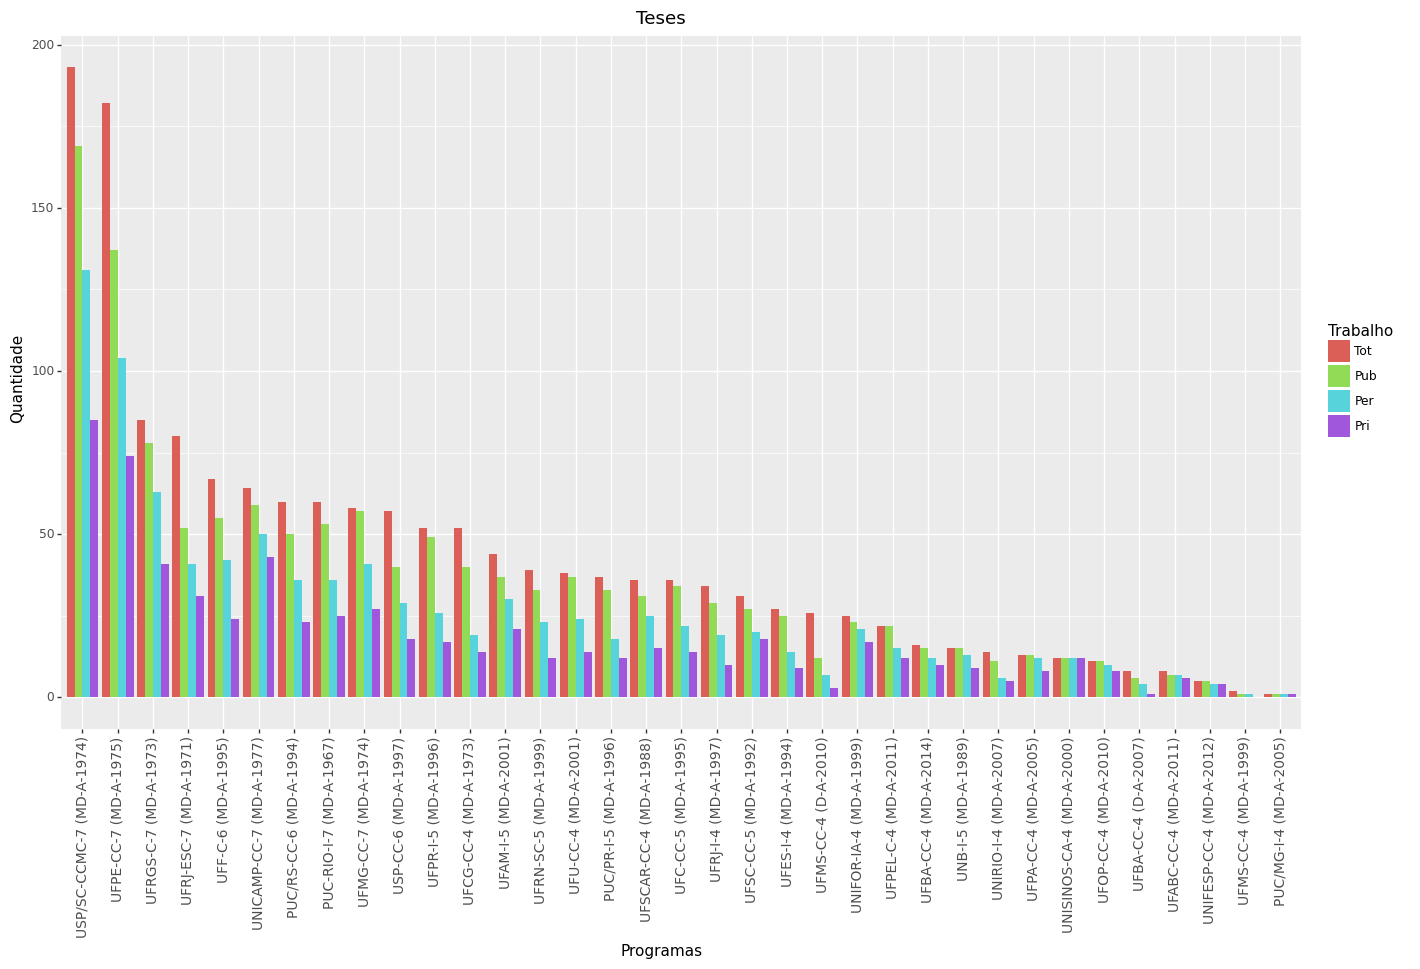

<ggplot: (8733811888245)>

In [ ]:
plottcc(
    sheets['tcc'][sheets['tcc']['Subtipo'] == "TESE"], 
    "TESE", 
    "Teses",
    incluirPub=["Pub", "Per", "Pri"]
  )

###Teses de doutorado por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


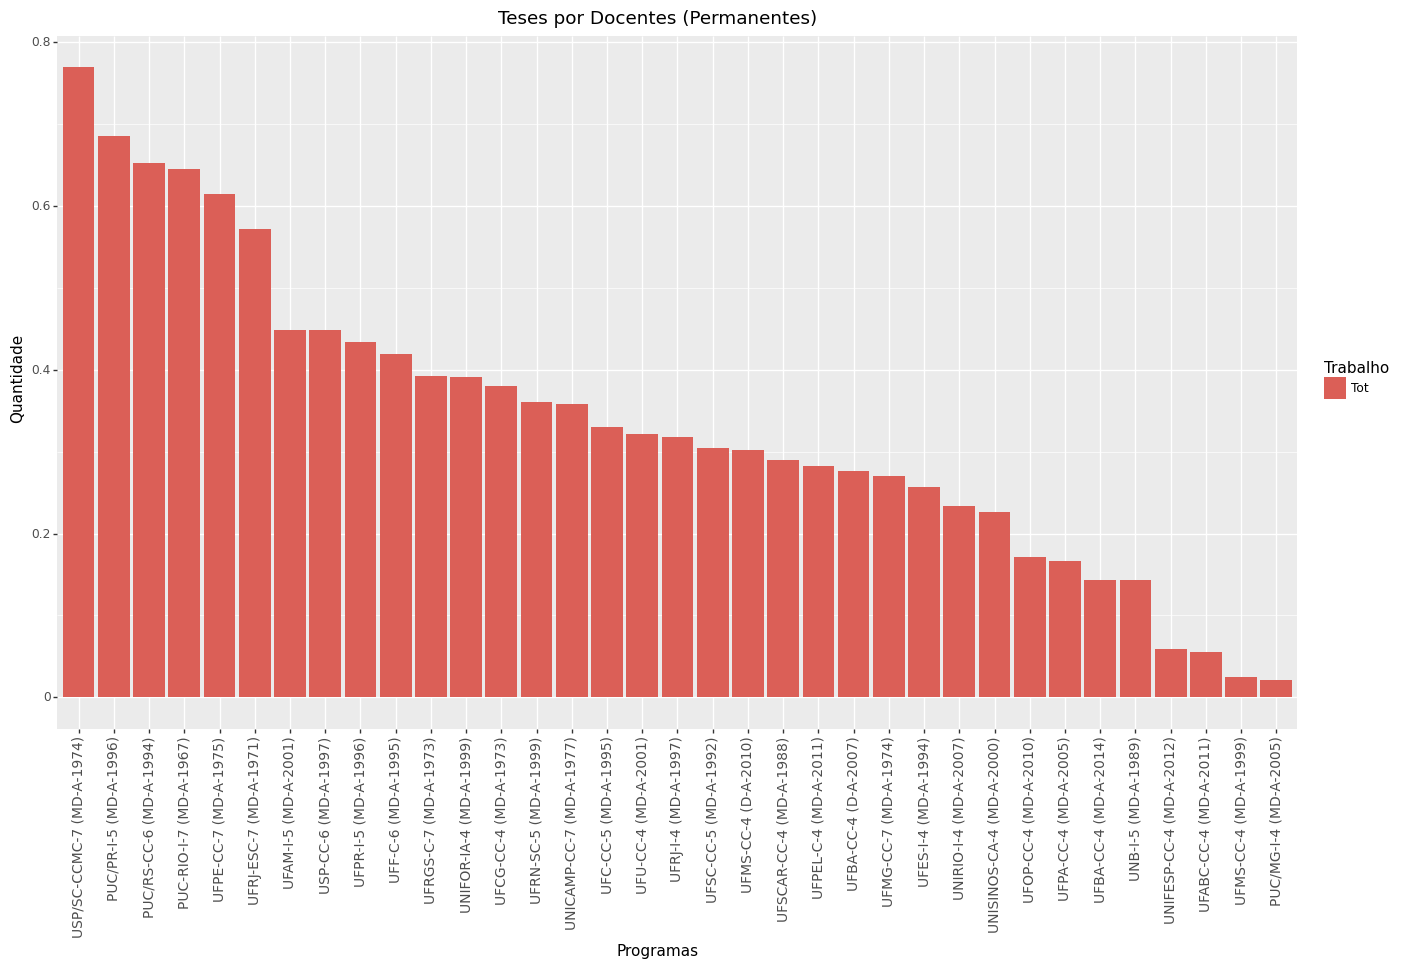

<ggplot: (8733816388153)>

In [ ]:
plottcc(
    sheets['tcc'][sheets['tcc']['Subtipo'] == "TESE"], 
    "TESE", 
    "Teses por Docentes (Permanentes)",
    ponderar=sumario_docentes[["Cod PPG", "PERMANENTE"]].rename(columns={"PERMANENTE": "Qte"})
  )

### Idioma das teses

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


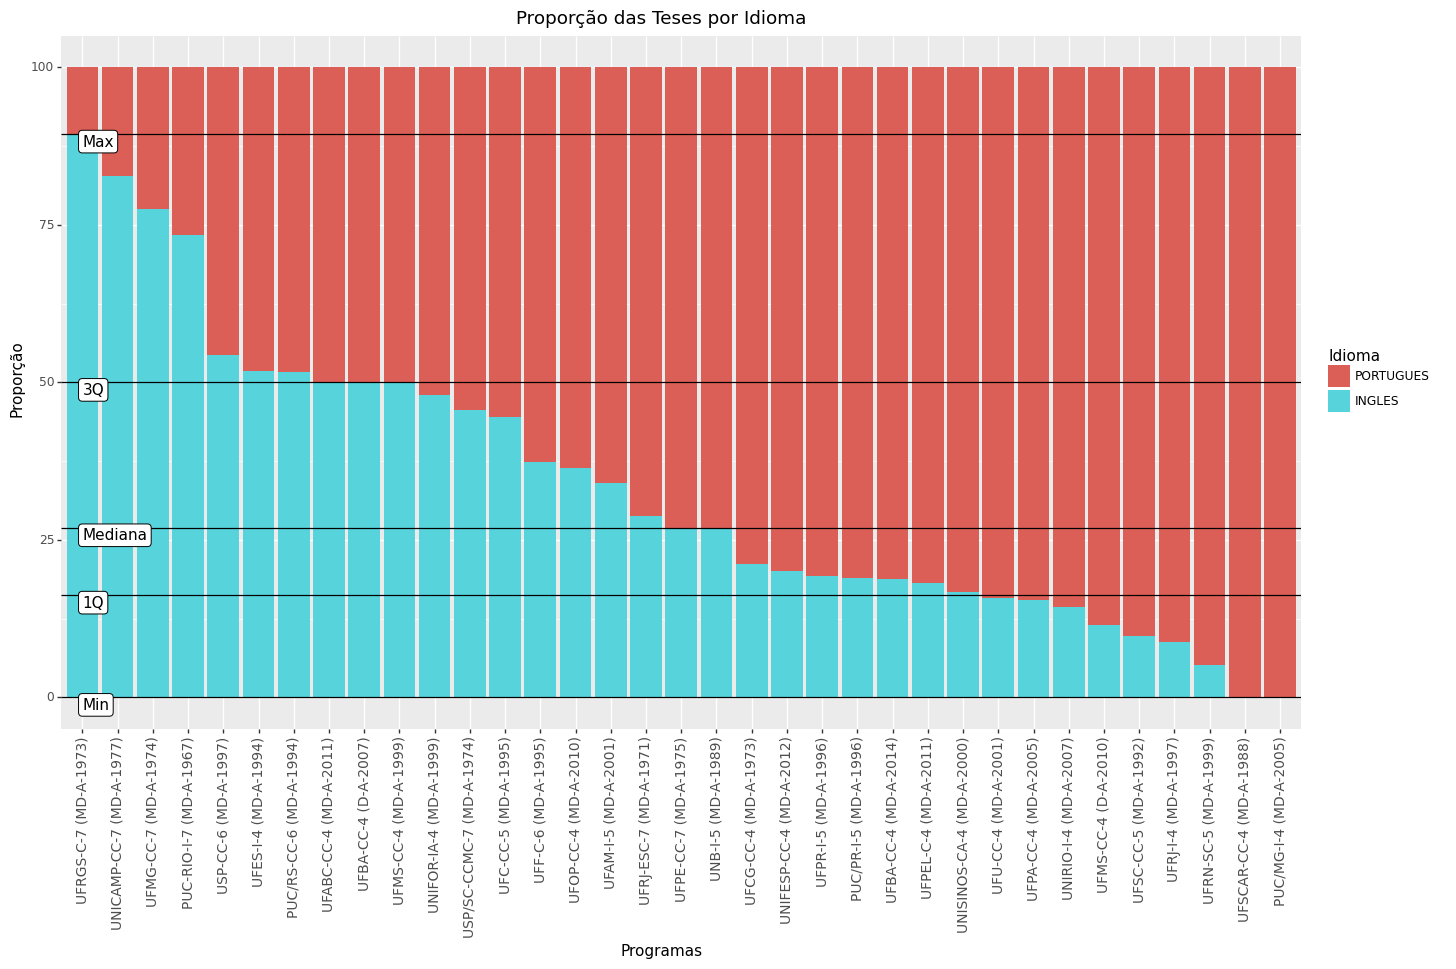

<ggplot: (8733812332765)>

In [ ]:
wd = sheets['tcc']
wd = wd[
        (wd['Idioma'].isin(["INGLES", "PORTUGUES"])) &
        (wd['Subtipo'].isin(["TESE"]))
        ]
gg = plotIdiomas(wd, addmedian=True)
(
  gg 
  + ggtitle('Proporção das Teses por Idioma')
  + labs(x="Programas", y="Proporção")
) 

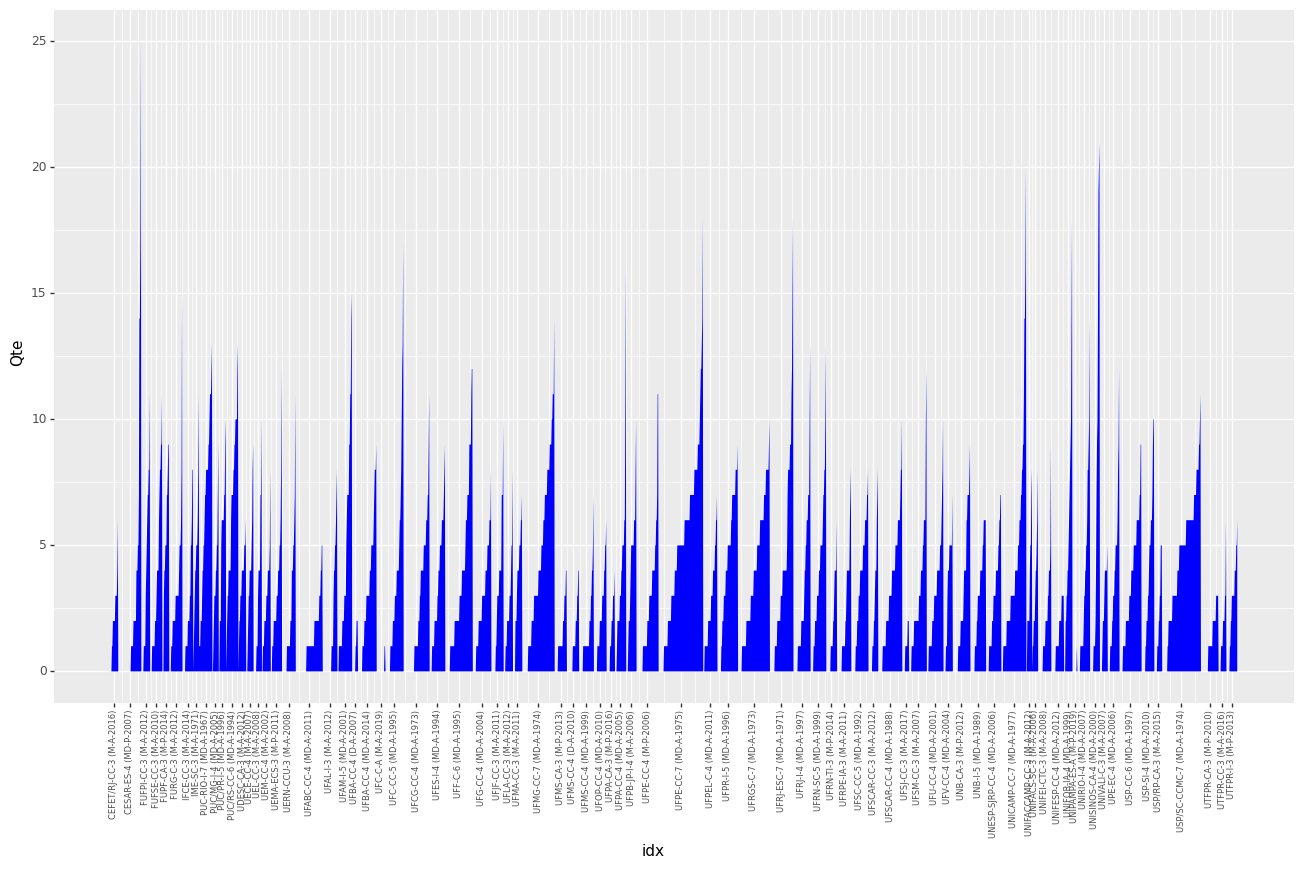

<ggplot: (8733815968393)>

In [ ]:
wd = sheets['docentes']

docs = wd[['Cod PPG', 'Nome do docente']] \
        .groupby(['Cod PPG', 'Nome do docente']).size().reset_index() \
        [['Cod PPG', 'Nome do docente']]

wd = sheets['tcc']

#wd = wd[wd['Subtipo'] == 'DISSERTAÇÃO']

wd = wd[['Cod PPG', 'Nome do orientador', 'Nome do Discente', 'Subtipo']] \
        .groupby(['Cod PPG', 'Nome do orientador']).count().reset_index() \
        [['Cod PPG', 'Nome do orientador', 'Subtipo']] \
        .rename(columns={'Nome do orientador': 'Nome do docente', 'Subtipo': 'Qte'})

wd = docs.merge(wd, on=['Cod PPG', 'Nome do docente'], how='left') \
      .fillna(0)

temtcc = wd[['Cod PPG', 'Qte']].groupby(['Cod PPG']).sum().reset_index()
temtcc = list(set(temtcc[temtcc['Qte'] > 0]['Cod PPG'].values))

wd = wd[wd['Cod PPG'].isin(temtcc)]

plotCapela(wd)

##Dissertações

###Programas com mestrado – Total de Dissertações defendidas (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


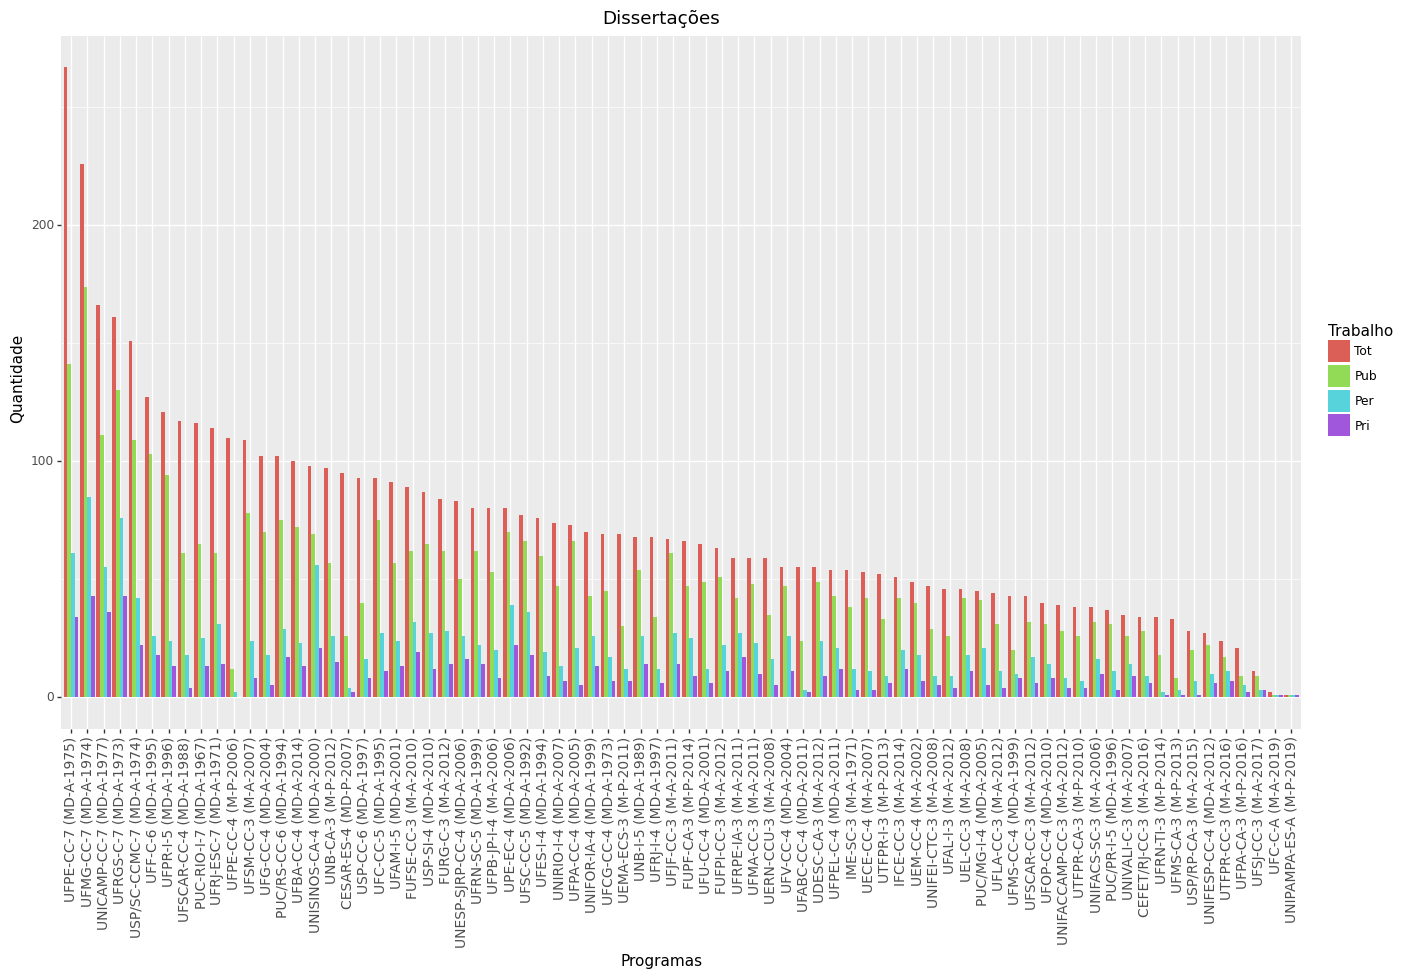

<ggplot: (8733813714129)>

In [ ]:
plottcc(
    sheets['tcc'][sheets['tcc']['Subtipo'] == "DISSERTAÇÃO"], 
    "DISSERTAÇÃO", 
    "Dissertações",
    incluirPub=["Pub", "Per", "Pri"]
  )

###Programas com mestrado – Total de Dissertações defendidas por docente (por ano) <<< conferir

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


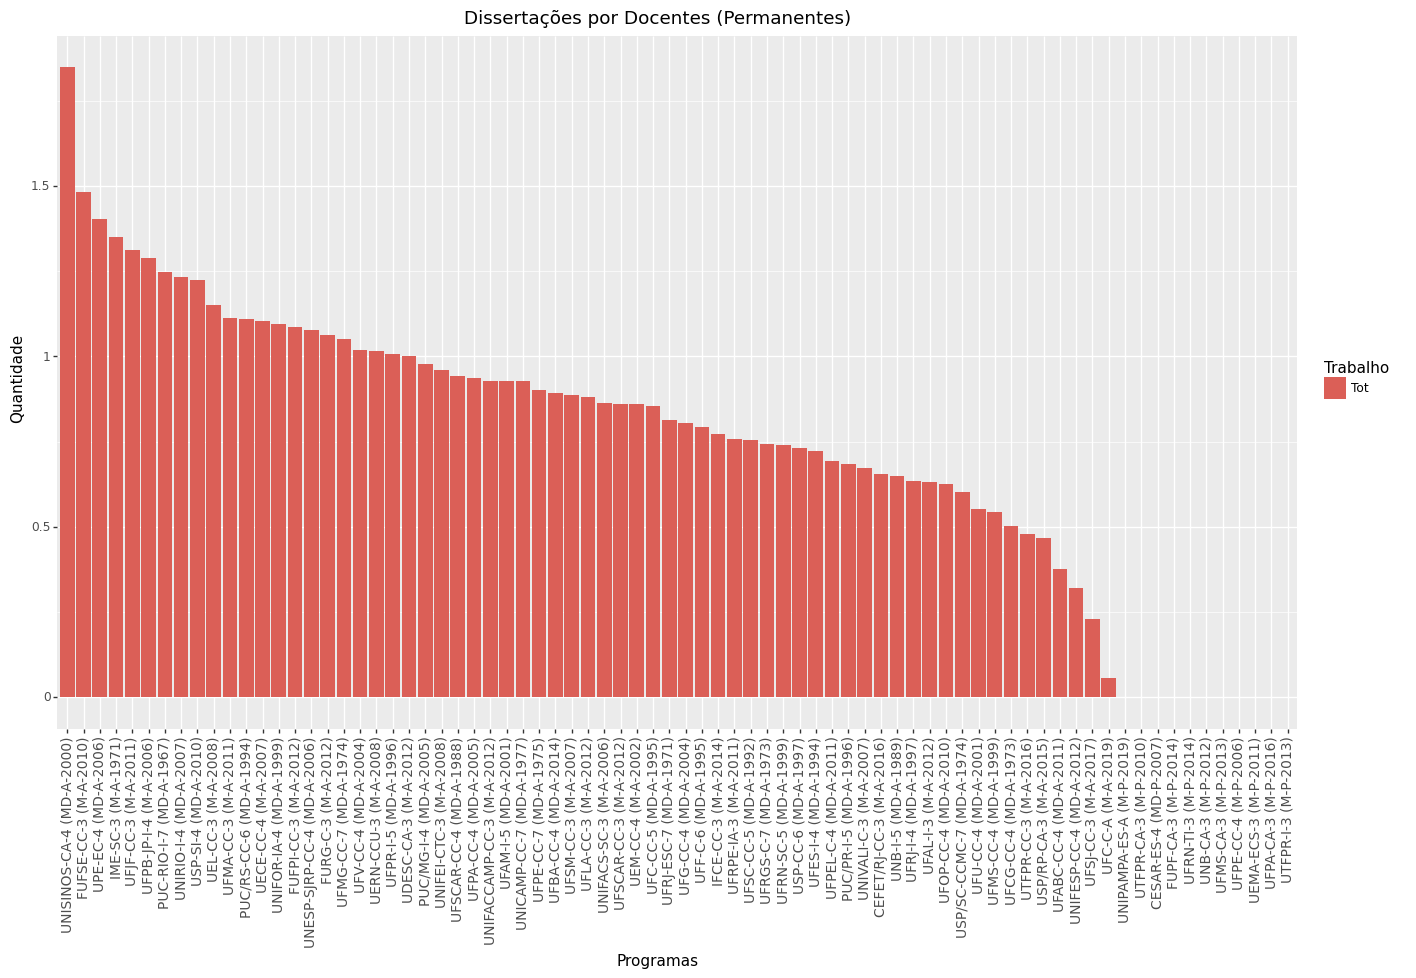

<ggplot: (8733816240245)>

In [ ]:
plottcc(
    sheets['tcc'][sheets['tcc']['Subtipo'] == "DISSERTAÇÃO"], 
    "DISSERTAÇÃO", 
    "Dissertações por Docentes (Permanentes)",
    ponderar=sumario_docentes[["Cod PPG", "PERMANENTE"]].rename(columns={"PERMANENTE": "Qte"})
  )

In [ ]:
wd = sheets['tcc']
wd = wd[wd['Subtipo'] == 'DISSERTAÇÃO']

aut = sumario_autores[
                      (sumario_autores['Natureza'] == "TRABALHO COMPLETO")
][['Cod PPG', 'Nome do docente']].groupby(['Cod PPG', 'Nome do docente']).count().reset_index()

wd = wd[['Cod PPG', 'Nome do Discente']]

wd_aut = wd.merge(aut, left_on=['Cod PPG', 'Nome do Discente'], right_on=['Cod PPG', 'Nome do docente'], how="inner").drop('Nome do docente', axis=1)

wd = wd.groupby('Cod PPG').count().reset_index().rename(columns={'Nome do Discente': 'Mestre'}) \
  .merge(wd_aut.groupby('Cod PPG').count().reset_index().rename(columns={'Nome do Discente': 'Mestre com Publicação'}), on='Cod PPG', how='left')
wd = wd.merge(siglas, on='Cod PPG', how='left')
wd['% Mestre com Publicação'] = wd['Mestre com Publicação'] / wd['Mestre']

wd = wd.sort_values('% Mestre com Publicação')

order = wd.sort_values('% Mestre com Publicação')['Sigla'].values

wd['Sigla'] = pd.Categorical(wd["Sigla"], categories=order)
wd

,Cod PPG,Mestre,Mestre com Publicação,Sigla,% Mestre com Publicação
17,25001019062P6,110,12,UFPE-CC-4 (M-P-2006),0.109091
72,51001012038P1,33,8,UFMS-CA-3 (M-P-2013),0.242424
20,25019015001P0,95,26,CESAR-ES-4 (MD-P-2007),0.273684
2,15001016092P4,21,9,UFPA-CA-3 (M-P-2016),0.428571
44,33002010176P0,93,40,USP-CC-6 (MD-A-1997),0.430108
...,...,...,...,...,...
1,15001016047P9,73,66,UFPA-CC-4 (MD-A-2005),0.904110
37,32005016034P8,67,61,UFJF-CC-3 (M-A-2011),0.910448
40,32008015011P7,45,41,PUC/MG-I-4 (MD-A-2005),0.911111
54,40002012033P5,46,42,UEL-CC-3 (M-A-2008),0.913043


##Periódicos

###IRestrito em periódicos

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


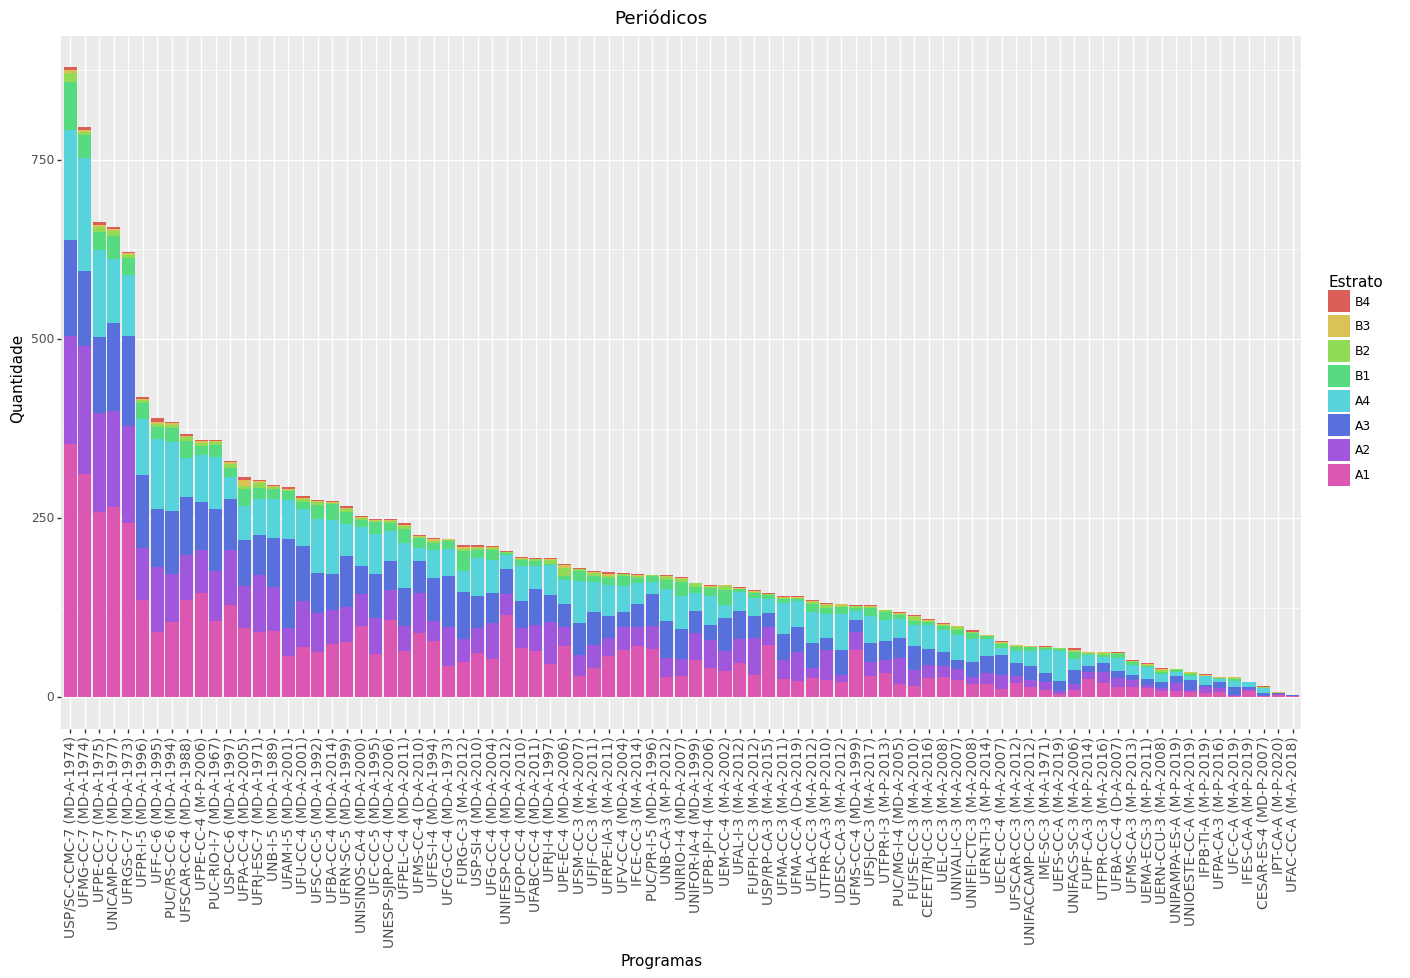

<ggplot: (8733813551813)>

In [ ]:
plotPublicacaoQualis(sumario_prod[sumario_prod["Subtipo"].isin(["ARTIGO EM PERIÓDICO"])], titulo="Periódicos", addmedian=False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


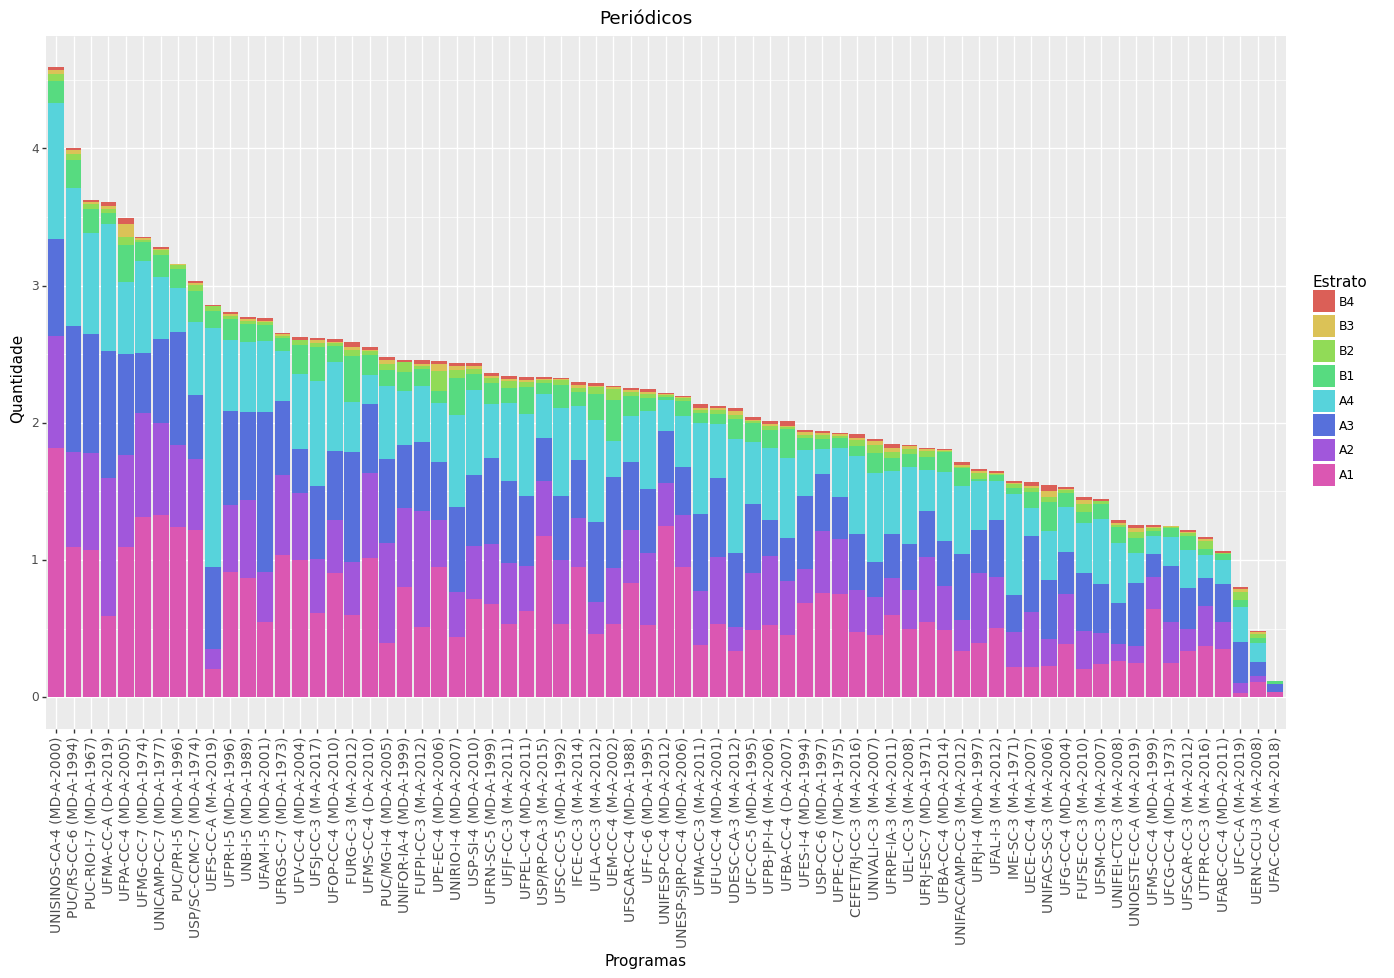

<ggplot: (8733815899677)>

In [ ]:
plotPublicacaoQualis(
    ponderar_por_docs(
        sumario_prod[sumario_prod["Subtipo"].isin(["ARTIGO EM PERIÓDICO"])],
        sumario_docentes, estratos
      ), titulo="Periódicos", addmedian=False
    )

###IRestrito em periódicos por docente (por ano) – sem ESWA, JSS, Neurocomputing, Information Sciences

In [ ]:
### Todo

### Distribuição interna de periódicos e índice Gini (todos os periódicos)

In [ ]:
autores_per = sumario_autores.loc[
  (sumario_autores['Subtipo'].isin(["ARTIGO EM PERIÓDICO"])) & 
  (sumario_autores['Estrato'].isin(estratos)) &
  (sumario_autores['Natureza'] == 'TRABALHO COMPLETO')
]

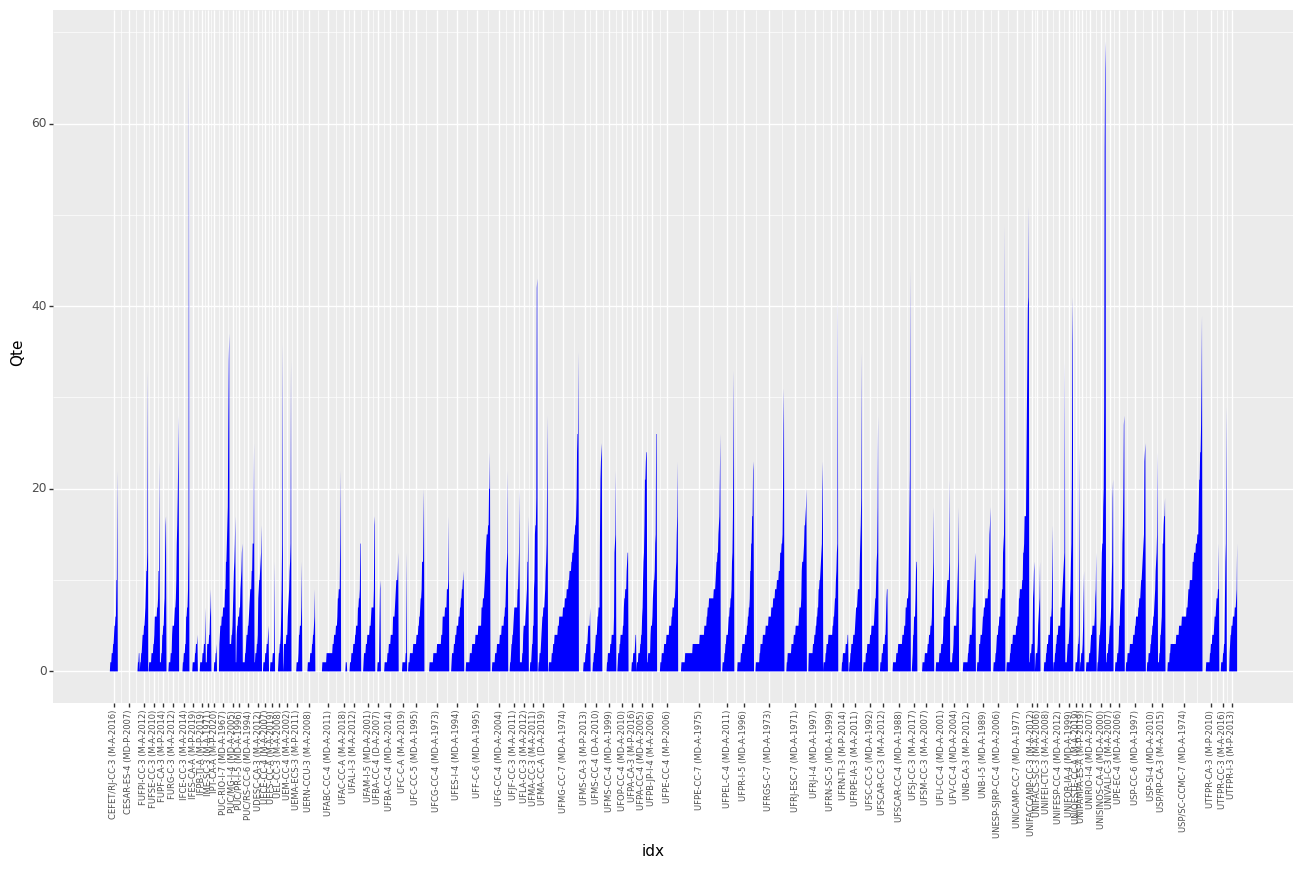

<ggplot: (8733815708153)>

In [ ]:
plotCapela(juntar_dados_hist(docentes, autores_per))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


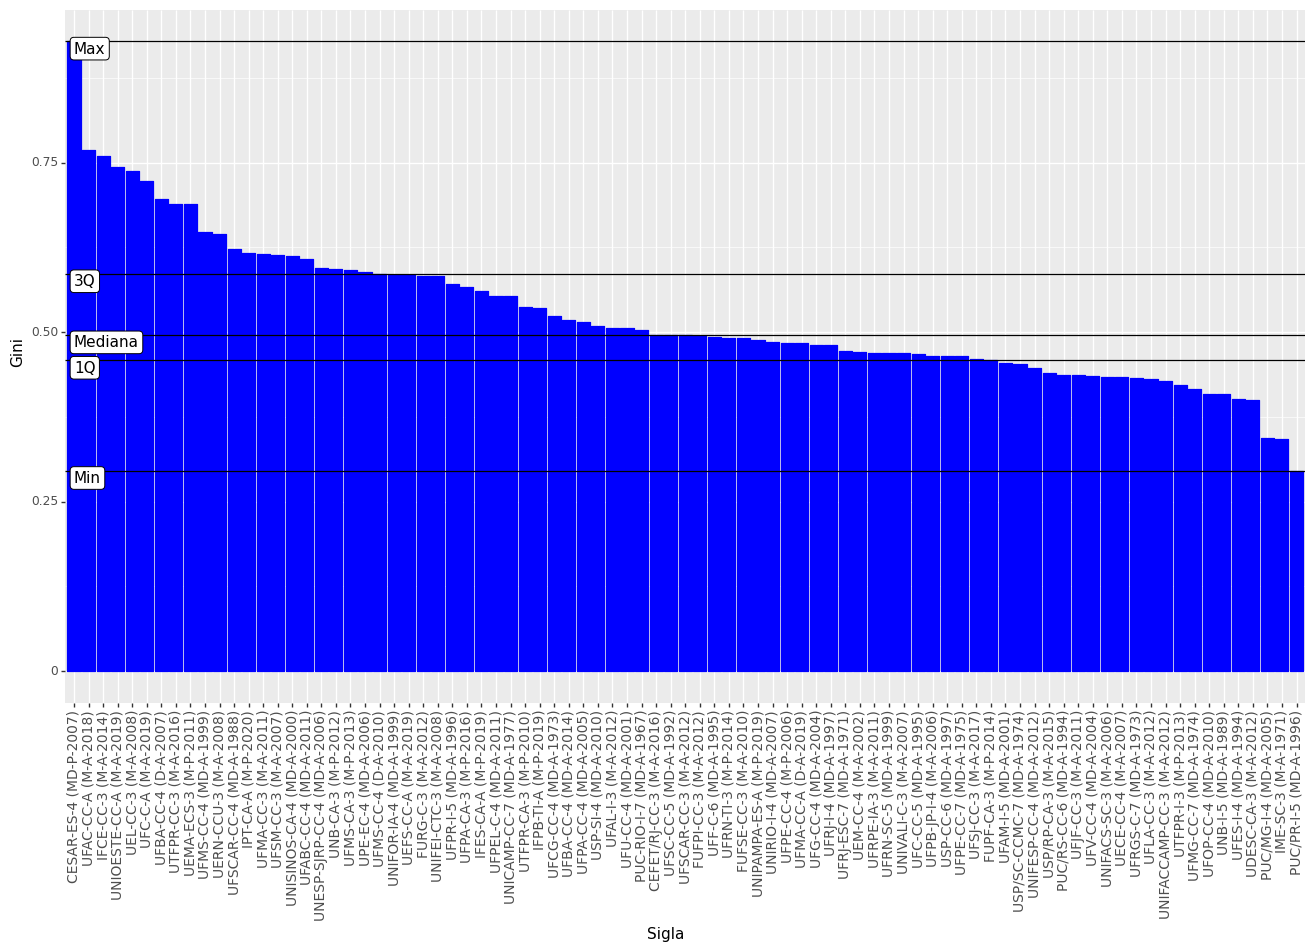

<ggplot: (8733812518569)>

In [ ]:
plotHist(juntar_dados_gini(docentes, autores_per), addmedian=True)

### Nuvem de Autores

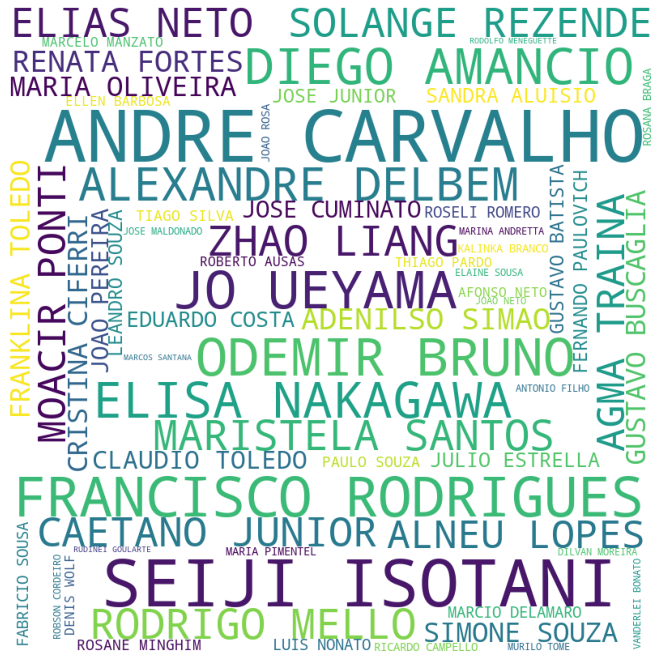

In [ ]:
plotNuvemPalavras(sumario_autores.loc[
                              (sumario_autores['Cod PPG'] == "33002045004P1") &
                              (sumario_autores['Cat'] == 'DOCENTE PERMANENTE') &
                              (sumario_autores['Subtipo'] == 'ARTIGO EM PERIÓDICO') &
                              (sumario_autores['Natureza'] == 'TRABALHO COMPLETO') &
                              (sumario_autores['Estrato'].isin(estratos))
                  ]['Nome do docente'].values, indices=[0, -1])

## Periódicos + Conferencias

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


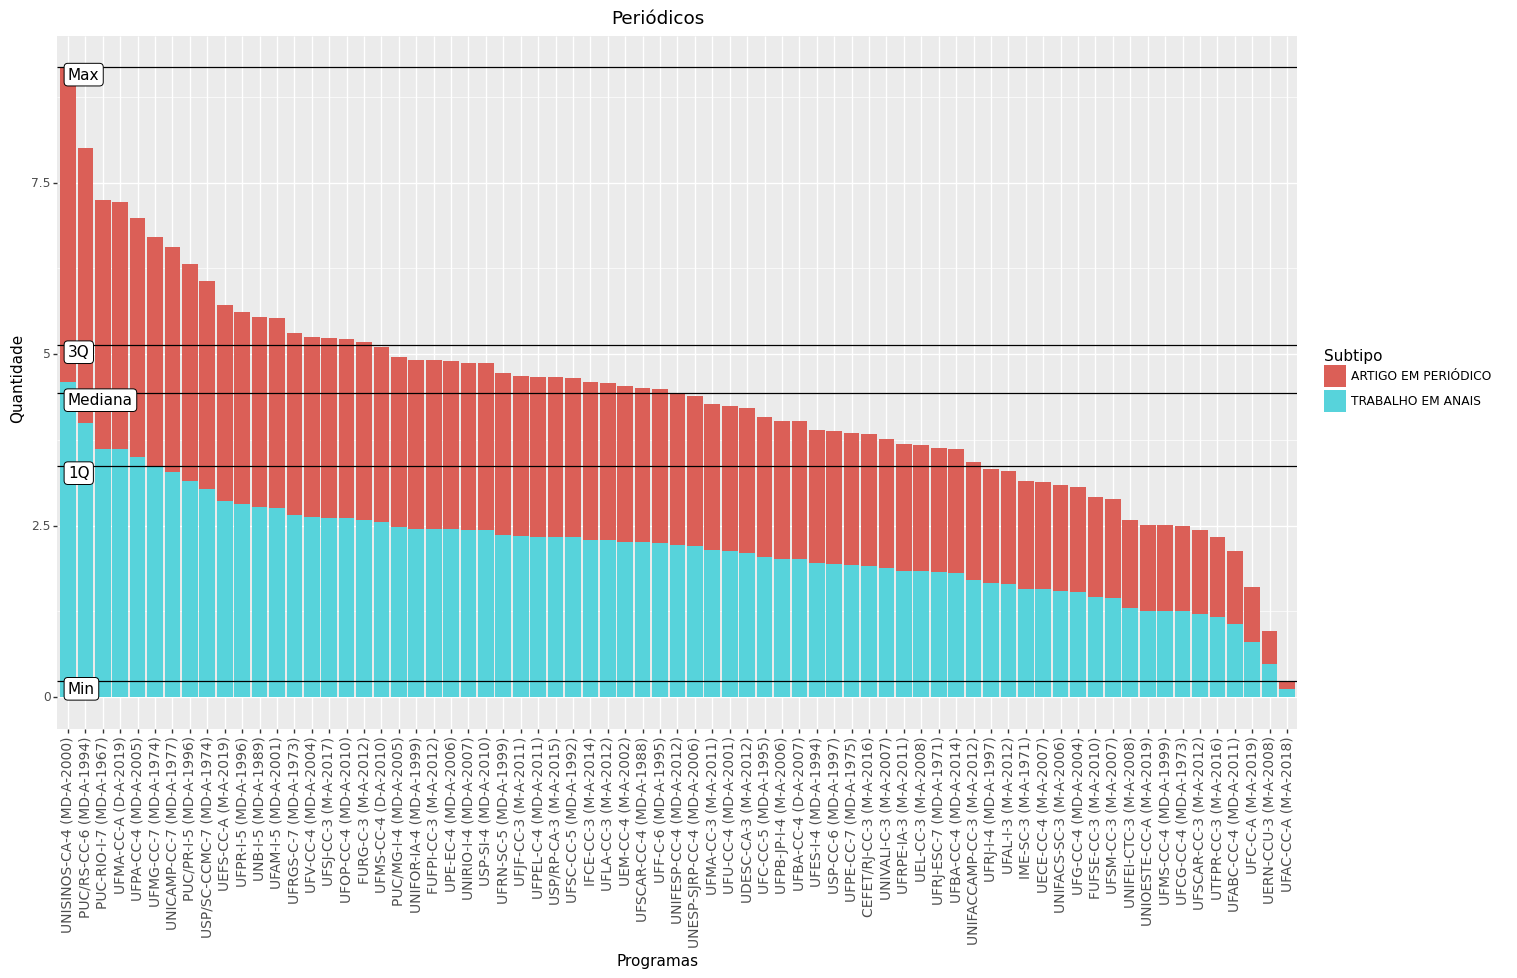

<ggplot: (8733815889249)>

In [ ]:
plotPublicacaoQualis(
    ponderar_por_docs(
        sumario_prod[
                     (sumario_prod["Subtipo"].isin(["ARTIGO EM PERIÓDICO", "TRABALHO EM ANAIS"]))
                  ],
        sumario_docentes, estratos
      ), titulo="Periódicos", fill="Subtipo", addmedian=True
    )

## Participação Discente nas Publicações

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


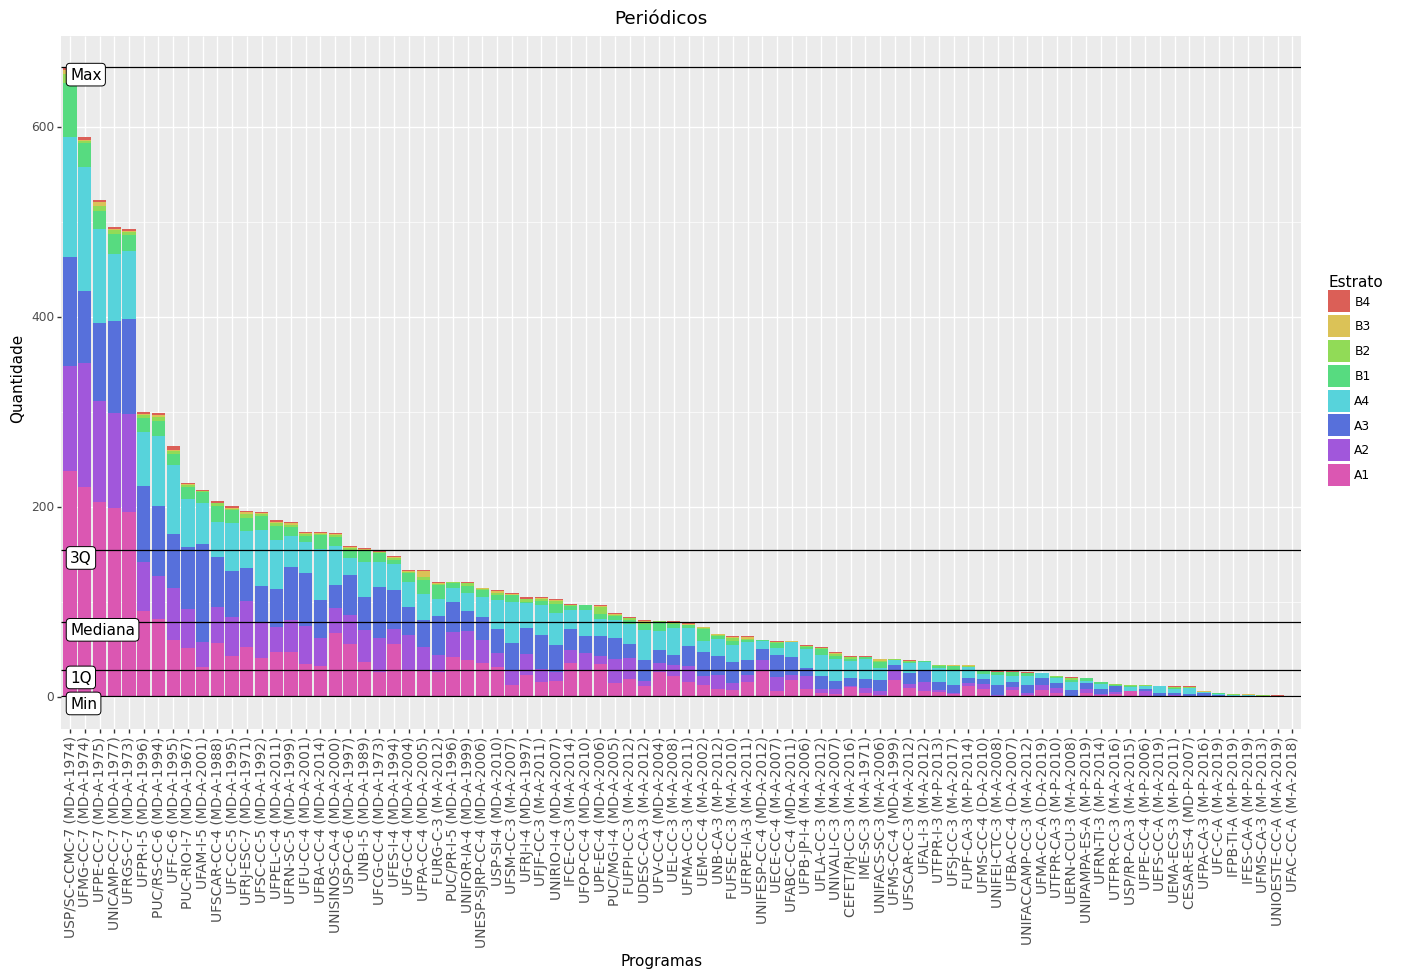

<ggplot: (8733813517761)>

In [ ]:
plotPublicacaoQualis(
    sumario_prod_disc[
                     (sumario_prod_disc["Subtipo"].isin(["ARTIGO EM PERIÓDICO"]))
                  ],
    titulo="Periódicos", fill="Estrato", addmedian=True
    )

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


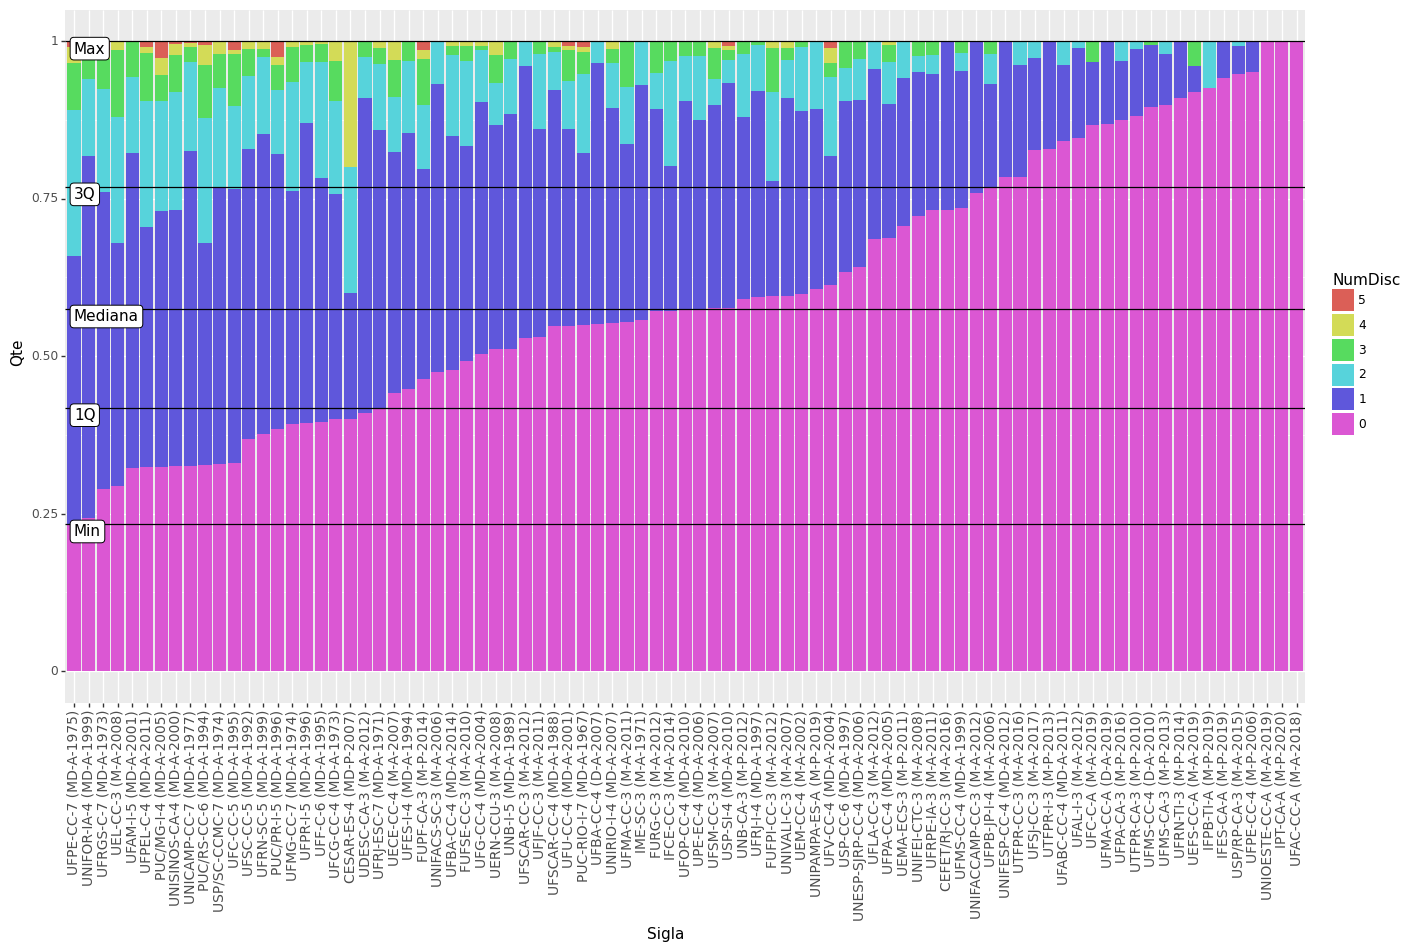

<ggplot: (8733816605809)>

In [ ]:
plotNumDisc(sumario_autores[sumario_autores["Subtipo"] == "ARTIGO EM PERIÓDICO"], addmedian=True)

#Temporario

In [ ]:
d = sheets['tcc']

In [ ]:
d[['Cod PPG', 'Subtipo']][d['Cod PPG'] == '33002045004P1'].groupby(['Subtipo']).count().reset_index()

,Subtipo,Cod PPG
0,DISSERTAÇÃO,151
1,TESE,193


In [ ]:
sumario_prod_disc

,Cod PPG,Subtipo,B4,B3,B2,B1,A4,A3,A2,A1
0,20001010022P0,ARTIGO EM PERIÓDICO,20.0,7.0,2.0,5.0,31.0,28.0,19.0,16.0
1,42003016038P9,ARTIGO EM PERIÓDICO,33.0,13.0,17.0,28.0,83.0,53.0,30.0,48.0
2,32006012017P2,ARTIGO EM PERIÓDICO,35.0,11.0,7.0,14.0,52.0,75.0,45.0,35.0
3,25004018011P1,ARTIGO EM PERIÓDICO,19.0,15.0,36.0,9.0,30.0,27.0,10.0,35.0
4,24009016005P0,ARTIGO EM PERIÓDICO,12.0,5.0,5.0,19.0,42.0,72.0,41.0,26.0
...,...,...,...,...,...,...,...,...,...,...
79,32008015011P7,TRABALHO EM ANAIS,21.0,10.0,5.0,8.0,31.0,29.0,29.0,15.0
80,41002016023P2,TRABALHO EM ANAIS,15.0,16.0,9.0,12.0,51.0,29.0,6.0,12.0
81,33001014044P0,TRABALHO EM ANAIS,11.0,4.0,3.0,2.0,17.0,16.0,4.0,10.0
82,32002017027P2,TRABALHO EM ANAIS,12.0,1.0,4.0,20.0,32.0,18.0,11.0,26.0


In [ ]:
sheets['tcc'][['Nome do Discente', 'Grau acadêmico']].groupby('Grau acadêmico').size()

Grau acadêmico
DOUTORADO                1510
MESTRADO                 4939
MESTRADO PROFISSIONAL     641
dtype: int64

In [ ]:
sheets['tcc']

,Unnamed: 0,Ano Base,Cod PPG,Nome PPG,Área Básica,IES Principal Sigla,IES Principal Nome,IES da Rede Sigla,Status Jurídico,UF,...,Nº\nMestrado,Nº\nDoutorado,Nº\nBacharelado,Indicador diversidade TCC (\ndissertações com pelo menos um PE sem vínculo com a IES ou Tese com pelo menos dois PE sem vínculo com a IES ),Total de Produções Vinculadas,Identificador das Produções Vinculadas (ID_ADD_PRODUCAO_INTELECTUAL),ID_ADD_TCC,ID_ADD_FOTO_PROGRAMA_IES_PRINC,ID_ADD_FOTO_PROGRAMA,Tipo de Clientela
0,0,2017.0,12001015012P2,INFORMÁTICA,CIÊNCIA DA COMPUTAÇÃO,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS,NaN,FEDERAL,AM,...,0.0,1.0,0.0,NÃO,0.0,NaN,29818472.0,172714.0,106397.0,AVALIAÇÃO
1,1,2017.0,12001015012P2,INFORMÁTICA,CIÊNCIA DA COMPUTAÇÃO,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS,NaN,FEDERAL,AM,...,0.0,3.0,0.0,SIM,0.0,NaN,29818473.0,172714.0,106397.0,AVALIAÇÃO
2,2,2017.0,12001015012P2,INFORMÁTICA,CIÊNCIA DA COMPUTAÇÃO,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS,NaN,FEDERAL,AM,...,0.0,3.0,0.0,NÃO,0.0,NaN,29818474.0,172714.0,106397.0,AVALIAÇÃO
3,3,2017.0,12001015012P2,INFORMÁTICA,CIÊNCIA DA COMPUTAÇÃO,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS,NaN,FEDERAL,AM,...,0.0,2.0,0.0,NÃO,0.0,NaN,29818475.0,172714.0,106397.0,AVALIAÇÃO
4,4,2017.0,12001015012P2,INFORMÁTICA,CIÊNCIA DA COMPUTAÇÃO,UFAM,UNIVERSIDADE FEDERAL DO AMAZONAS,NaN,FEDERAL,AM,...,0.0,3.0,0.0,SIM,1.0,29824796,29818476.0,172714.0,106397.0,AVALIAÇÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7085,7085,2020.0,53001010098P3,COMPUTAÇÃO APLICADA,CIÊNCIA DA COMPUTAÇÃO,UNB,UNIVERSIDADE DE BRASÍLIA,NaN,FEDERAL,DF,...,0.0,1.0,0.0,SIM,1.0,33043042,33043317.0,204614.0,135951.0,AVALIAÇÃO
7086,7086,2020.0,53001010098P3,COMPUTAÇÃO APLICADA,CIÊNCIA DA COMPUTAÇÃO,UNB,UNIVERSIDADE DE BRASÍLIA,NaN,FEDERAL,DF,...,0.0,1.0,0.0,SIM,1.0,33043225,33043318.0,204614.0,135951.0,AVALIAÇÃO
7087,7087,2020.0,53001010098P3,COMPUTAÇÃO APLICADA,CIÊNCIA DA COMPUTAÇÃO,UNB,UNIVERSIDADE DE BRASÍLIA,NaN,FEDERAL,DF,...,0.0,2.0,0.0,SIM,0.0,NaN,33043319.0,204614.0,135951.0,AVALIAÇÃO
7088,7088,2020.0,53001010098P3,COMPUTAÇÃO APLICADA,CIÊNCIA DA COMPUTAÇÃO,UNB,UNIVERSIDADE DE BRASÍLIA,NaN,FEDERAL,DF,...,0.0,1.0,0.0,SIM,1.0,33043013,33043320.0,204614.0,135951.0,AVALIAÇÃO


In [ ]:
tcc = sheets['tcc']

tcc[['Cod PPG', 'Subtipo', 'Ano Base']][tcc['Cod PPG'].isin(['25001019004P6'])].groupby(['Subtipo']).count().reset_index()

,Subtipo,Cod PPG,Ano Base
0,DISSERTAÇÃO,267,267
1,TESE,182,182
